# Notebook project MASEF "Monte Carlo and Finite Difference"

In [2]:
# Import 
import os
import gc
from abc import ABC, abstractmethod
from typing import Union

import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Gaussian random variables generation

The aim of this class is to avoid to generate multiple sample of gaussian to create the various plots in the notebook.  
At the begining we instantiate this class to generate a lot of gaussian random variables and write them on the disc to avoid to have RAM issue (time consuming).  
Each times we needs some gaussian random variable we are going to use this class to get samples.  
If there are not available not used samples the class will generate new samples.  
We will reinitialize counter at each use.

In [3]:
class GenerateGaussian:
    def __init__(self, total_nb_samples: int, batch_size: int, filename: str = "gaussian_memmap.dat") -> None:
        self.total_nb_samples = total_nb_samples # nb of samples we generate and write on the disc with memmap
        self.batch_size = batch_size # batch size of creating/writing (to adjust in function of RAM)
        self.filename = filename # name of the file on the disc containing data
        self.samples = np.memmap(self.filename,
                                 dtype='float64',
                                 mode='w+',
                                 shape=(self.total_nb_samples,)) # usage of memmap to not overload RAM                                
        self.get_new_samples(nb_samples=total_nb_samples)
        self.samples.flush()
        self.counter = 0 # counter to be sure we do not use same data multiple time for a simulation
        
        self.alert_needed_more_samples = False
    
    def get_new_samples(self, nb_samples: int):
        if self.batch_size > nb_samples:
            batch_size = nb_samples
        else:
            batch_size = self.batch_size
            
        num_batches = (nb_samples + batch_size - 1) // batch_size    
        samples_list = []
        # We use batch to avoid to overload memory
        for b in range(num_batches):
            start_idx = b * batch_size
            end_idx = min(start_idx + batch_size, nb_samples)
            current_batch_size = end_idx - start_idx
            
            self.samples[start_idx:end_idx] = np.random.randn(current_batch_size)

    def random_randn(self, nb_samples: int, nb_step: int) -> np.ndarray:
        total_needed = nb_samples * nb_step
        
        if self.counter + total_needed > self.total_nb_samples:
            result = np.random.randn(nb_samples, nb_step) # if not enough we simulate other gaussian
            self.alert_needed_more_samples = True # we notify that we had to simulate more gaussian
            
        else:          
            start = self.counter
            end = self.counter + total_needed
            self.counter = end

            result = self.samples[start:end].reshape(nb_samples, nb_step)
            
        return result


# Dynamic memory management

In the following notebook we are going to manipulate very large array and so the RAM is going to be very solicitate.  
To avoid that RAM is overload at each moment of the code we need to manipulate large date we split it into smaller batch.  
The default is that using batch inspite of making one big vectorized computation we are going to make loop and make small vectorized computation that can take slightly more time.  
So if you have a lot of RAM avalaibility you can increase batch size and in the opposite case lower it. 

In [4]:
###
# TO MODIFY IN FUNCTION OF YOUR RAM AVAILABILITY
###

"""
This parameter will affect the functionnement of the algorithm. Result won't be affect by this variable only time of execution
If your have large RAM availability you can increase this value as it speed up the execution with vectorize code
If you have some memory issue while running the code down lower it
"""

batch_size = 10**5 # memory parameter to control batch size during various computation (to adapt in function of your RAM)

# NB: 10**5 work well with 8 Go RAM

In [5]:
###
# NOT MANDATORY TO RUN BUT HIGHLY RECOMMANDED TO EFFICIENTLY RUN ALL NOTEBOOK AT ONCE (approx 1-2 min)
###

# Max is Lookback top right plot with 4*10**6 path (paper) and 4**5 step of discretization (highest nb of samples)
# Before running again this code run restart the kernel

total_nb_samples = int(4.048*10**9)
generate_gaussian = GenerateGaussian(total_nb_samples=total_nb_samples, batch_size=batch_size)

# Price Models

Here is the implementation of Euler sheme of two well-known financial models:

1) Geometric Brownian Motion under the risk-neutral measure (associated with the numeraire induced by the interest rate $r$), with the following stochastic differential equation
$$
    dS_t 
    = r S_t \, dt 
      + \sigma \, S_t \, dW_t,
    \quad S_0 \text{ given},
$$
where $r$ is the constant interest rate on the market, $\sigma > 0$ is the volatility, and $W_t$ denotes a standard Brownian motion.

2) The Heston stochastic volatility model describes the joint dynamics of an asset price $S_t$ and its variance $V_t$. Under the risk-neutral measure, the model is given by
$$
\begin{aligned}
dS_t &= r\,S_t\,dt 
       \;+\; \sqrt{V_t}\,S_t \, dW_t^1, \\[6pt]
dV_t &= \lambda\bigl(\theta - V_t\bigr)\,dt 
       \;+\; \xi\,\sqrt{V_t}\,dW_t^2,
\end{aligned}
$$
with initial conditions $S_0 > 0$, $V_0 > 0$. Here:
- $r$ is the constant risk-free interest rate.
- $\theta$ is the long-term mean of $V_t$.
- $\lambda$ is the rate at which $V_t$ reverts to $\theta$.
- $\xi$ is the volatility-of-volatility parameter.
- $W_t^1$ and $W_t^2$ are Brownian motions with correlation $\rho$, i.e.,
  $\mathrm{d}\langle W^1, W^2\rangle_t = \rho \, \mathrm{d}t$.


In [6]:
class PriceModel(ABC):
    @abstractmethod
    def get_dynamics(self) -> np.ndarray:
        pass
    
    @abstractmethod
    def generate_BM(self) -> np.ndarray:
        pass
    
    @abstractmethod
    def reshape_increments(self) -> np.ndarray:
        pass
    
class GeometricBrownianMotion(PriceModel):
    
    def __init__(self, init_value: float, drift : float, sigma: float, generate_gaussian: GenerateGaussian=None) -> None:
        self.init_value_price = init_value
        self.drift = drift
        self.sigma = sigma # volatility param
        
        self.generate_gaussian = generate_gaussian # explain above the GenerateGaussian class
    
    def get_dynamics(self, nb_samples:int, nb_step: int, time_step: float, increment_bm: np.ndarray = None) -> np.ndarray:
        if increment_bm is None:
            DW=self.generate_BM(nb_samples=nb_samples, nb_step=nb_step, time_step=time_step) # BM discretization with M_L step
        else:
            DW = increment_bm

        S = np.zeros((nb_samples, nb_step + 1)) # Discretization of time step L
        S[:, 0] = self.init_value_price
        S[:, 1:] = self.init_value_price*np.cumprod(1 + self.drift * time_step + self.sigma * DW, axis=1)
        
        return S
    
    def generate_BM(self, nb_samples:int, nb_step: int, time_step: float) -> np.ndarray:
        if self.generate_gaussian is None:
            DW=np.sqrt(time_step)*np.random.randn(nb_samples, nb_step)
        else:
            DW=np.sqrt(time_step)*self.generate_gaussian.random_randn(nb_samples=nb_samples, nb_step=nb_step)
        
        return DW
    
    def reshape_increments(self, nb_samples: float, increments: np.ndarray, refinement_factor: int) -> np.ndarray:
        increments_reshaped = increments.reshape(nb_samples, -1, refinement_factor).sum(axis=2) 

        return increments_reshaped
    
class HestonStochasticVolatility(PriceModel):
    
    def __init__(self, init_value_price: float, init_value_vol: float, drift: float, sigma: float, 
                 lambda_: float, ksi: float, rho: float, generate_gaussian: GenerateGaussian=None) -> None:
        self.init_value_price = init_value_price # init price value
        self.init_value_vol = init_value_vol # init stochastic volatility value
        self.drift = drift # drift of price dynamics
        self.sigma = sigma # mean of stochastic volatility
        self.lambda_ = lambda_ # mean reversion parameter
        self.ksi = ksi # volatility of stochastic volatility parameter
        self.rho = rho # correlation between diffusion
        
        self.generate_gaussian = generate_gaussian # explain above the GenerateGaussian class
    
    def get_dynamics(self, nb_samples:int, nb_step: int, time_step: float, increment_bm: np.ndarray = None) -> np.ndarray:
        if increment_bm is None:
            dW1, dW2 = self.generate_BM(nb_samples=nb_samples, nb_step=nb_step, time_step=time_step)
        else:
            dW1 = increment_bm[0]
            dW2 = increment_bm[1]

        S = np.zeros((nb_samples, nb_step + 1))
        V = np.zeros((nb_samples, nb_step + 1))

        S[:, 0] = self.init_value_price
        V[:, 0] = self.init_value_vol

        for n in range(nb_step):
            V[:, n + 1] = self.sigma**2 + np.exp(-self.lambda_ * time_step) * (V[:, n] - self.sigma**2) + self.ksi * np.sqrt(V[:, n]) * dW2[:, n]
            V[:, n + 1] = np.maximum(V[:, n + 1], 0)  # Ensure non-negativity
            S[:, n + 1] = S[:, n] + self.drift * S[:, n] * time_step + np.sqrt(V[:, n]) * S[:, n] * dW1[:, n]
        
        return S  
    
    def generate_BM(self, nb_samples:int, nb_step: int, time_step: float) -> np.ndarray:
        if self.generate_gaussian is None:
            Z1 = np.random.randn(nb_samples, nb_step)
            Z2 = np.random.randn(nb_samples, nb_step)
        else:
            Z1 = self.generate_gaussian.random_randn(nb_samples=nb_samples, nb_step=nb_step)
            Z2 = self.generate_gaussian.random_randn(nb_samples=nb_samples, nb_step=nb_step)
        
        dW1 = np.sqrt(time_step) * Z1
        dW2 = np.sqrt(time_step) * (self.rho * Z1 + np.sqrt(1 - self.rho**2) * Z2)
        
        return [dW1, dW2]
    
    def reshape_increments(self, nb_samples: float, increments: np.ndarray, refinement_factor: int) -> np.ndarray:
        increments_reshaped_1 = increments[0].reshape(nb_samples, -1, refinement_factor).sum(axis=2) 
        increments_reshaped_2 = increments[1].reshape(nb_samples, -1, refinement_factor).sum(axis=2) 

        return [increments_reshaped_1, increments_reshaped_2]

# Option Payoff

Here is the implementation of option payoffs that can depend on either the terminal value of the price or the entire trajectory.   
The following options are implemented in order: European vanilla option, Asian option, Lookback option, and Digital option.  
We provide further details on the approximation of the payoffs implemented in these classes in the plot section below.


In [7]:
class OptionPayoff(ABC):
    @abstractmethod
    def get_payoff(self, trajectories: np.ndarray, extra_param: dict=None) -> np.array:
        pass
    
class EuropeanVanillaOption(OptionPayoff):
    
    def __init__(self, maturity: float, strike: float, type_option: str) -> None:
        self.maturity = maturity # maturity of the option
        self.strike = strike # strike at which the option can be exercised
        self.type_option = type_option # Call or Put option
        
    def get_payoff(self, trajectories: np.ndarray, extra_param: dict=None) -> np.array:
        if self.type_option == "CALL":        
            payoff = np.maximum(trajectories[:,-1] - self.strike, 0)
        elif self.type_option == "PUT":        
            payoff = np.maximum(self.strike - trajectories[:,-1], 0)
        else:
            raise Exception("Unknown EU option")
        
        return payoff

class AsianOption(OptionPayoff):
    
    def __init__(self, maturity: float, strike: float, type_option: str) -> None:
        self.maturity = maturity # maturity of the option
        self.strike = strike # strike at which the option can be exercised
        self.type_option = type_option # Call or Put option
        
    def get_payoff(self, trajectories: np.ndarray, extra_param: dict=None) -> np.array:
        time_step = extra_param["time_step"]
        T = (trajectories.shape[1]-1)*time_step
        #rieman_aprox = np.mean(trajectories, axis=1)
        trapeze_aprox = 0.5 * time_step * np.sum(trajectories[:, :-1] + trajectories[:, 1:], axis=1) # trapeze aprox of integral
        mean_traj = trapeze_aprox / T # mean of each trajectories
        if self.type_option == "CALL":
            payoff = np.maximum(mean_traj - self.strike, 0)
        elif self.type_option == "PUT":        
            payoff = np.maximum(self.strike - mean_traj, 0)
        else:
            raise Exception("Unknown Asian option")
        
        return payoff

class LookbackOption(OptionPayoff):
    
    def __init__(self, maturity: float) -> None:
        self.maturity = maturity # maturity of the option
        
    def get_payoff(self, trajectories: np.ndarray, extra_param: dict=None) -> np.array:
        volatility = extra_param["volatility"]
        time_step = extra_param["time_step"]
        beta = 0.5826
        min_path = np.min(trajectories, axis=1)*(1-beta*volatility*np.sqrt(time_step)) # paper
        
        payoff = trajectories[:,-1] - min_path
        
        return payoff

class DigitalOption(OptionPayoff):
    
    def __init__(self, maturity: float, strike: float, type_option: str) -> None:
        self.maturity = maturity # maturity of the option
        self.strike = strike # strike at which the option can be exercised
        self.type_option = type_option # Call or Put option
        
    def get_payoff(self, trajectories: np.ndarray, extra_param: dict=None) -> np.array:
        if self.type_option == "CALL":        
            payoff = (trajectories[:,-1] - self.strike > 0).astype(int)
        elif self.type_option == "PUT":        
            payoff = (self.strike - trajectories[:,-1] > 0).astype(int)
        else:
            raise Exception("Unknown EU option")
        
        return payoff

# Multi Level Parametrization

In [8]:
class ParamMultiLevel:
    
    def __init__(self, accuracy: float, refinement_factor: int, init_nb_samples: int, 
                 richardson_ext: bool, batch_size: int = None) -> None:
        self.accuracy = accuracy # epsilon in the paper (aimed RMSE)
        self.refinement_factor = refinement_factor # M in the paper (refinement factor of geometric time step)
        self.init_nb_samples = init_nb_samples # init number of samples for discretization L (step 2)
        
        self.richardson_ext = richardson_ext # use or not Richardson extrapolation (change estimator and convergence test)
        
        self.batch_size = batch_size # memory parameter to free up memory between two batch in path simulation (usefull for large simulation)
        
    def compute_final_estimator(self, Y_l_array: np.array) -> float:
        if self.richardson_ext:
            M = self.refinement_factor
            final_estimator = sum(Y_l_array) + (1/(M-1))*Y_l_array[-1] # expression write above eq 11
        else:
            final_estimator = sum(Y_l_array) # sum of all term of telescopic sum (just before eq 3)
        
        return final_estimator
        
    def test_convergence(self, Y_L: float, Y_L_1: float) -> bool:
        if self.richardson_ext:
            test = self.test_richardson_ext(Y_L=Y_L, Y_L_1=Y_L_1)        
        else:
            test = self.test_classic(Y_L=Y_L, Y_L_1=Y_L_1)
        
        return test
    
    def test_classic(self, Y_L: float, Y_L_1: float) -> bool:
        test = False
        M = self.refinement_factor
        epsilon = self.accuracy
        
        if max(abs(Y_L_1)/M, abs(Y_L)) < (M-1)*epsilon/np.sqrt(2):
            test = True
        
        return test
    
    def test_richardson_ext(self, Y_L: float, Y_L_1: float) -> bool:
        test = False
        M = self.refinement_factor
        epsilon = self.accuracy
        
        if abs(Y_L - Y_L_1/M) < (M**2-1)*epsilon/np.sqrt(2):
            test = True
        
        return test

# Mutli Level Monte Carlo

Here is the class that implement the multi-level algorithm.  
The methods is based on the following decomposition at different refinenemnt level (geometric sequence $M^l$) of Euler sheme
$$
\mathbb{E}[\widehat{P}_L] = \mathbb{E}[\widehat{P}_0] + \sum_{l=1}^L \mathbb{E}[\widehat{P}_l - \widehat{P}_{l-1}]
$$
The goal is to achieve an aimed MSE $\epsilon^2$ that can be decomposed as 
$$
MSE = \mathbb{E}((\widehat{Y} - \mathbb{E}(P))^2) = V(\widehat{Y}) + (\mathbb{E}(\widehat{Y}) - \mathbb{E}(P))^2
$$
So if $V(\widehat{Y}) < \frac {1}{2\epsilon^2}$ and $\mathbb{E}(\widehat{Y}) - \mathbb{E}(P) < \frac {1}{\sqrt{2}\epsilon}$ we have that $MSE < \epsilon^2$.  
The first condition is ensure by the optimal number of sample choice $N_l$ :
$$
N_l = \left\lceil 2 \epsilon^{-2} \sqrt{V_l h_l} \left( \sum_{l=0}^L \sqrt{\frac{V_l}{h_l}} \right) \right\rceil.
$$
While the second is ensure by the stopping criterion of the algorithm : 
As $\mathbb{E}(\hat{P_l} - \hat{P}_{l-1}) \approx (M-1)\mathbb{E}(P - \hat{P}_l)$ we can have the following termination condition
$$
\max\left\{ M^{-1} |\widehat{Y}_{L-1}|, |\widehat{Y}_L| \right\} < \frac{1}{\sqrt{2}} (M-1) \epsilon, \quad Y_L = P_L - P_{L-1}
$$
We can also eliminate the leading order bias by using Richardson extrapolation with the following termination condition
$$
\widehat{Y}_L - M^{-1} \widehat{Y}_{L-1}| \leq \frac{1}{\sqrt{2}} (M^2 - 1) \epsilon
 $$
and the following adapted estimator of the price
$$
\left( \sum_{l=0}^L \widehat{Y}_l \right) + (M - 1)^{-1} \widehat{Y}_L
$$

The algorithm is as follow :

1. **Initialization:** Set $L = 0$.
2. **Variance estimation:** Estimate $V_L$ using an initial set of $N_L = 10^4$ samples.
3. **Define the optimal number of samples:** Compute $N_l$, $l = 0, \dots, L$.
4. **Sample refinement:** Evaluate extra samples at each level as needed for the new $N_l$ values.
5. **Convergence test:** If $L \geq 2$, test for convergence using one of the criterion.
6. **Iteration:** If $L < 2$ or if convergence is not achieved, set $L := L + 1$ and return to Step 2.


In [9]:
class MultiLevelMonteCarlo:
    
    def __init__(self, price_model: PriceModel, option_payoff: OptionPayoff, param_multi_level: ParamMultiLevel) -> None:
        self.price_model = price_model
        self.option_payoff = option_payoff
        self.param_multi_level = param_multi_level
        
        # flash memory array of mean, variance and nb of sample to avoid to compute them many times
        self.P_l_diff_array = [] # sample of payoff difference for different fineness of the grid l
        self.Y_l_array = [] # estimator of mean of payoff difference at each fineness of the grid l
        self.V_l_array = [] # variance of estimator at each fineness of the grid l
        self.N_l_array = [] # number of sample at each fineness of the grid l
        
        self.N_l_optimal_array = [] # optimal number of sample at each fineness of the grid l (not known in advance)
     
    def get_price(self) -> float:
        acceptable_accuracy = False
        L = 0 # init L (step 1)
        N_L = self.param_multi_level.init_nb_samples
        epsilon = self.param_multi_level.accuracy
        
        self.P_l_diff_array = [] # reinitialize
        self.Y_l_array = []
        self.V_l_array = []
        self.N_l_array = []
        self.N_l_optimal_array = []
        
        
        while acceptable_accuracy == False:
            # Computation of new samples of difference of payoff
            P_L_diff = self.get_sample_diff_payoff(L=L, N_L=N_L)
                        
            # Computation of variance, mean and update array(step 2)
            self.P_l_diff_array.append(P_L_diff)
            
            Y_L = np.mean(P_L_diff)
            self.Y_l_array.append(Y_L)
            
            V_L = np.var(P_L_diff)
            self.V_l_array.append(V_L)
            
            self.N_l_array.append(N_L)
                         
            # Optimal number of sample for each fineness of the grid l (step 3)
            sum_V_h_L = sum([np.sqrt(self.V_l_array[l]/(T*M**(-l))) for l in range(L+1)]) # sum in equation 12
            optimal_N_l_array = [math.ceil((2*epsilon**(-2))*np.sqrt(self.V_l_array[l]*(T*M**(-l)))*sum_V_h_L) for l in range(L+1)]
            
            
            # Evaluation of extra sample if necessary (step 4)
            for l in range(L+1):
                if optimal_N_l_array[l] > self.N_l_array[l]:
                    # Computation of extra samples
                    nb_extra_sample_l = optimal_N_l_array[l] - self.N_l_array[l]

                    M_l = M**(l) # number of discretization step
                    h_l = T/M_l # time step
                    
                    P_l_diff_extra = self.get_sample_diff_payoff(L=l, N_L=nb_extra_sample_l)
                    P_l_diff = np.concatenate((self.P_l_diff_array[l], P_l_diff_extra)) # new P_l contain old value and new ones
                    
                    # Update array
                    self.P_l_diff_array[l] = P_l_diff
                    
                    Y_l = np.mean(P_l_diff)
                    self.Y_l_array[l] = Y_l

                    V_l = np.var(P_l_diff)
                    self.V_l_array[l] = V_l

                    self.N_l_array[l] = optimal_N_l_array[l]
            
            # Test for convergence (step 5)
            if L >= 2:
                Y_L = self.Y_l_array[-1] # most finest difference
                Y_L_1 = self.Y_l_array[-2] # second most finest difference
                test_convergence = self.param_multi_level.test_convergence(Y_L=Y_L, Y_L_1=Y_L_1)
            
            # Determine to stop algorithm (step 6)
            if L < 2 or test_convergence==False:
                L += 1
            else:
                acceptable_accuracy = True
                self.N_l_optimal_array = optimal_N_l_array
        
        final_estimator = self.param_multi_level.compute_final_estimator(Y_l_array=self.Y_l_array) # depends on convergence test
        
        return final_estimator
    
    def get_sample_payoff(self, L: int, N_L: int) -> np.array:
        
        if self.param_multi_level.batch_size is None:
            batch_size=N_L
        elif self.param_multi_level.batch_size > N_L:
            batch_size=N_L
        else:
            batch_size = self.param_multi_level.batch_size
        num_batches = (N_L + batch_size - 1) // batch_size
        
        
        P_L_list = []
        # We use batch to avoid to overload memory
        for b in range(num_batches):
            start_idx = b * batch_size
            end_idx = min(start_idx + batch_size, N_L)
            current_batch_size = end_idx - start_idx
            
            P_L_list.append(self.get_sample_payoff_batch(L=L, N_L=current_batch_size))
            
        return np.concatenate(P_L_list, axis=0)
    
    def get_sample_diff_payoff(self, L: int, N_L: int) -> np.array:
        
        if self.param_multi_level.batch_size is None:
            batch_size=N_L 
        elif self.param_multi_level.batch_size > N_L:
            batch_size=N_L
        else:
            batch_size = self.param_multi_level.batch_size
        num_batches = (N_L + batch_size - 1) // batch_size
        
        
        P_L_diff_list = []
        # We use batch to avoid to overload memory
        for b in range(num_batches):
            start_idx = b * batch_size
            end_idx = min(start_idx + batch_size, N_L)
            current_batch_size = end_idx - start_idx
            
            P_L_diff_list.append(self.get_sample_diff_payoff_batch(L=L, N_L=current_batch_size))
            
        return np.concatenate(P_L_diff_list, axis=0)

    
    def get_sample_payoff_batch(self, L: int, N_L: int) -> np.array: 
        # Used only for plot purpose
        # L is the index of the geometric discretization
        # N_L is the number of sample we want to compute
        
        S_0 = self.price_model.init_value_price
        r = self.price_model.drift
        sigma = self.price_model.sigma
        T = self.option_payoff.maturity
        M = self.param_multi_level.refinement_factor
        
        M_L = M**(L) # number of discretization step
        h_L = T/M_L # time step
        
        S_L = self.price_model.get_dynamics(nb_samples=N_L, 
                                            nb_step=M_L, 
                                            time_step=h_L)

        extra_param = {"volatility": sigma, "time_step": h_L} # used only for lookback option
        P_L = np.exp(-r*T)*self.option_payoff.get_payoff(trajectories=S_L, extra_param=extra_param) # payoff discounted
        
        return P_L
        
    def get_sample_diff_payoff_batch(self, L: int, N_L: int) -> np.array:
        # L is the index of the geometric discretization (geometric**L step)
        # N_L is the number of sample we want to compute
        
        S_0 = self.price_model.init_value_price
        r = self.price_model.drift
        sigma = self.price_model.sigma
        T = self.option_payoff.maturity
        M = self.param_multi_level.refinement_factor
        
        M_L = M**(L) # number of discretization step
        h_L = T/M_L # time step       
        DW = self.price_model.generate_BM(nb_samples=N_L, 
                                            nb_step=M_L, 
                                            time_step=h_L) # BM discretization with M_L step
        
        S_L = self.price_model.get_dynamics(nb_samples=N_L, 
                                            nb_step=M_L, 
                                            time_step=h_L, 
                                            increment_bm=DW)
        
        extra_param = {"volatility": sigma, "time_step": h_L} # used only for lookback option
        P_L = np.exp(-r*T)*self.option_payoff.get_payoff(trajectories=S_L, extra_param=extra_param) # payoff discounted

        if L != 0:
            # we denote by variable_1 to explicit the fact that its L-1 fine step          
            M_L_1 = int(M_L/M)
            h_L_1 = T/M_L_1
            DW_1 = self.price_model.reshape_increments(nb_samples=N_L, increments=DW, refinement_factor=M)# BM discretization with M_L / M step
            
            S_L_1 = self.price_model.get_dynamics(nb_samples=N_L,
                                                  nb_step=M_L_1,
                                                  time_step=h_L_1,
                                                  increment_bm=DW_1)
            
            extra_param_1 = {"volatility": sigma, "time_step": h_L_1} # used only for lookback option estimator
            P_L_1 = np.exp(-r*T)*self.option_payoff.get_payoff(trajectories=S_L_1, extra_param=extra_param_1) # payoff discounted
            
            P_L_diff = P_L - P_L_1 # estimator of mean of difference between two level of fineness
            
        else:
            P_L_diff = P_L # if L=0 the estimator is the first term of telescopic sum Y_0
        
        return P_L_diff
    
    def get_time_complexity(self) -> float:
        # Used to plot bottom right plot in numerical result part
        if len(self.N_l_optimal_array) == 0:
            raise Exception("Run get_price before to check your time complexity")
            
        L = len(self.N_l_optimal_array) - 1
        M = self.param_multi_level.refinement_factor
        C_L_array = [self.N_l_optimal_array[0]] + [self.N_l_optimal_array[l]*(M**l + M**(l-1)) for l in range(1,L+1)] # formula just before numerical results
        C = sum(C_L_array)
        
        return C
    
    def get_confidence_interval(self, price: float, confidence: float) -> Union[float, float]:
        if len(self.N_l_optimal_array) == 0:
            raise Exception("Run get_price before getting confidence interval")
            
        if not (0 < confidence < 1):
            raise ValueError("Confidence must be between 0 et 1")
            
        alpha = 1 - confidence
        z = norm.ppf(1 - alpha / 2)
        
        variance = sum(self.V_l_array) # sum
        n = sum(self.N_l_optimal_array)
               
        interval = [price - z*np.sqrt(variance/n), price + z*np.sqrt(variance/n)]
        
        return interval
        
        

# Classical Monte Carlo

Implementation of Classic Monte Carlo algorithm.  
get_price() method is the naive implementation see in class.  
get_price_aim_accuracy is the implementation of Classic method with Multi Level algorithm as explained in the report with $N_l^* = 2\epsilon^{-2}V(P_l)$ number of samples at each level.

In [10]:
class ParamClassicMc:
    
    def __init__(self, nb_samples: int, refinement_euler: int, batch_size: int = None) -> None:
        self.nb_samples = nb_samples # number of samples     
        self.refinement_euler = refinement_euler # number of discretization step
        
        self.batch_size = batch_size # memory parameter to free up memory between two batch in path simulation (usefull for large simulation)

class ClassicMonteCarlo:
    
    def __init__(self, price_model: PriceModel, option_payoff: OptionPayoff, param_classic_mc: ParamClassicMc) -> None:
        self.price_model = price_model
        self.option_payoff = option_payoff
        self.param_classic_mc = param_classic_mc
        
        self.info_confidence_interval = None
    
    def get_price(self) -> float:
        N = self.param_classic_mc.nb_samples
        M = self.param_classic_mc.refinement_euler
   
        S_0 = self.price_model.init_value_price
        r = self.price_model.drift
        sigma = self.price_model.sigma
        T = self.option_payoff.maturity        
        h = T/M # time step
        
        S = self.price_model.get_dynamics(nb_samples=N,
                                          nb_step=M, 
                                          time_step=h)

        extra_param = {"volatility": sigma, "time_step": h} # used only for lookback option
        P = np.exp(-r*T)*self.option_payoff.get_payoff(trajectories=S, extra_param=extra_param) # payoff discounted
        
        estimator = np.mean(P)
        
        # confidence interval info
        variance = np.var(P)
        n=len(P)
        self.info_confidence_interval = {"variance": variance, "n": n}
        
        return estimator
    
    
    def get_price_aim_accuracy(self, param_multi_level: ParamMultiLevel) -> float:
        # classic MC with multi level algorithm to compare time complexity against accuracy
        acceptable_accuracy = False
        L = 0 # init L (step 1)
        N_L = param_multi_level.init_nb_samples
        epsilon = param_multi_level.accuracy
        
        self.P_l_array = [] # sample of payoff for different fineness of the grid l (not the difference here !)
        self.Y_l_array = [] # estimator of mean of payoff at each fineness of the grid l (not the difference here !)
        self.V_l_array = [] # variance of estimator at each fineness of the grid l
        self.N_l_array = [] # number of sample at each fineness of the grid l       
        self.N_l_optimal_array = [] # optimal number of sample at each fineness of the grid l (not known in advance)     
        
        while acceptable_accuracy == False:
            # Computation of new samples of difference of payoff
            M = param_multi_level.refinement_factor # refinement factor
            M_L = M**L # nb sample for L finest level
            P_L = self.get_sample_payoff(M=M_L, N=N_L)
                        
            # Computation of variance, mean and update array(step 2)
            self.P_l_array.append(P_L)
            
            Y_L = np.mean(P_L)
            self.Y_l_array.append(Y_L)
            
            V_L = np.var(P_L)
            self.V_l_array.append(V_L)
            
            self.N_l_array.append(N_L)
                         
            # Optimal number of sample for each fineness of the grid l (step 3)
            optimal_N_l_array = [math.ceil((2*epsilon**(-2))*self.V_l_array[l]) for l in range(L+1)]
            
            
            # Evaluation of extra sample if necessary (step 4)
            for l in range(L+1):
                if optimal_N_l_array[l] > self.N_l_array[l]:
                    # Computation of extra samples
                    nb_extra_sample_l = optimal_N_l_array[l] - self.N_l_array[l]

                    M_l = M**(l) # number of discretization step
                    h_l = T/M_l # time step
                    
                    P_l_extra = self.get_sample_payoff(M=M_l, N=nb_extra_sample_l)
                    P_l = np.concatenate((self.P_l_array[l], P_l_extra)) # new P_l contain old value and new ones
                    
                    # Update array
                    self.P_l_array[l] = P_l
                    
                    Y_l = np.mean(P_l)
                    self.Y_l_array[l] = Y_l

                    V_l = np.var(P_l)
                    self.V_l_array[l] = V_l

                    self.N_l_array[l] = optimal_N_l_array[l]
            
            # Test for convergence (step 5)
            if L >= 2:
                # compute the difference to make the test of multilevel algo
                P_L_mean_diff = self.Y_l_array[-1] - self.Y_l_array[-2]
                P_L_mean_diff_1 = self.Y_l_array[-2] - self.Y_l_array[-3]
                test_convergence = param_multi_level.test_convergence(Y_L=P_L_mean_diff, Y_L_1=P_L_mean_diff_1)
            
            # Determine to stop algorithm (step 6)
            if L < 2 or test_convergence==False:
                L += 1
            else:
                acceptable_accuracy = True
                self.N_l_optimal_array = optimal_N_l_array
        
        # compute the difference to compute final estimator of the form of multilevel algo
        Y_l_difference_array = [self.Y_l_array[0]] + [self.Y_l_array[i] - self.Y_l_array[i-1] for i in range(1, len(self.Y_l_array))]
        final_estimator = param_multi_level.compute_final_estimator(Y_l_array=Y_l_difference_array) # depends on convergence test
        
        return final_estimator
    
    def get_sample_payoff(self, M: int, N: int) -> np.array:
        # Used in multi level version of classic MC
        # M is the number of step in the discretization
        # N is the number of sample we want to compute
        
        S_0 = self.price_model.init_value_price
        r = self.price_model.drift
        sigma = self.price_model.sigma
        T = self.option_payoff.maturity
        h = T/M # time step
        extra_param = {"volatility": sigma, "time_step": h} # used only for lookback option
        
        if self.param_classic_mc.batch_size is None:
            batch_size = N
        elif self.param_classic_mc.batch_size > N:
            batch_size = N
        else:
            batch_size = self.param_classic_mc.batch_size
        num_batches = (N + batch_size - 1) // batch_size
        
        P_list = []
        # We use batch to avoid to overload memory
        for b in range(num_batches):
            start_idx = b * batch_size
            end_idx = min(start_idx + batch_size, N)
            current_batch_size = end_idx - start_idx
            
            S_batch = self.price_model.get_dynamics(nb_samples=current_batch_size,
                                                    nb_step=M,
                                                    time_step=h)
                

            P_batch = np.exp(-r*T) * self.option_payoff.get_payoff(trajectories=S_batch,
                                                                   extra_param=extra_param)
                

            P_list.append(P_batch)
            
            # Clean memory explicitly
            del S_batch, P_batch
            gc.collect()

        return np.concatenate(P_list, axis=0)
    
    def get_time_complexity(self, param_multi_level: ParamMultiLevel) -> float:
        # Used to plot bottom right plot in numerical result part
        if len(self.N_l_optimal_array) == 0:
            raise Exception("Run get_price_aim_accuracy before to check your time complexity")
            
        L = len(self.N_l_optimal_array) - 1
        M = param_multi_level.refinement_factor
        C_L_array = [self.N_l_optimal_array[l]*M**l for l in range(L+1)] # formula just before numerical results
        C = sum(C_L_array)
        
        return C
    
    def get_confidence_interval(self, price: float, confidence: float) -> Union[float, float]:
        # Confidence interval for classic Monte carlo algorithm and not modified with aimed accuracy
        if self.info_confidence_interval is None:
            raise Exception("Run get_price before getting confidence interval")
        
        if not (0 < confidence < 1):
            raise ValueError("Confidence must be between 0 et 1")
            
        alpha = 1 - confidence
        z = norm.ppf(1 - alpha / 2)
        
        variance = self.info_confidence_interval["variance"]
        n = self.info_confidence_interval["n"]
               
        interval = [price - z*np.sqrt(variance/n), price + z*np.sqrt(variance/n)]
        
        return interval
    
    

# Black and Scholes formula

In [11]:
def black_scholes_price(S_0, K, T, r, sigma, option_type) -> float:
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "CALL":
        price = S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "PUT":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S_0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'CALL' or 'PUT'.")

    return price

# Comparaison numerical methods (Main code)

In [12]:
# Reinitialize gaussian generation use counter
generate_gaussian.counter = 0

# Price dynamics
S_0 = 1 # init value of price
r = 0.05 # drift (interest rate on risk neutral)
sigma = 0.2 # volatility of price
price_model = GeometricBrownianMotion(init_value=S_0, 
                                      drift=r, 
                                      sigma=sigma,
                                      generate_gaussian=generate_gaussian)

# Option type
T = 1 # maturity of option
K = 1 # strike of option
type_option = "CALL" # type of option
option_payoff = EuropeanVanillaOption(maturity=T, 
                                      strike=K, 
                                      type_option=type_option)

# Parametrization of Multi Level algorithm
epsilon = 10**(-4) # accuracy (RMSE) to choose
M = 4 # refinement factor in the paper
N_L = 10**4 # init number of sample at each level in the paper (in step 2 of numerical algorithm)
richardson_ext = False # use or not Richardson extrapolation
confidence = 0.95 # value to use in confidence interval

param_multi_level= ParamMultiLevel(accuracy=epsilon, 
                                   refinement_factor=M, 
                                   init_nb_samples=N_L,
                                   richardson_ext=richardson_ext)

# Evaluation with Multi Level algorithm
multi_level_algorithm = MultiLevelMonteCarlo(price_model=price_model, 
                                             option_payoff=option_payoff, 
                                             param_multi_level=param_multi_level)

price_estimator_ml_mc = multi_level_algorithm.get_price()

conf_inter_multi_mc = multi_level_algorithm.get_confidence_interval(price=price_estimator_ml_mc, confidence=confidence)

# Black and Scholes price
BS_price = black_scholes_price(S_0, K, T, r, sigma, type_option)

# Monte Carlo price
# Here we do not aim to compare time complexity between classic and multi level algorithm (check plot part just below)
gamma=0 # to change for confidence interval (p29 in course)
nb_samples_classic_mc = 10**4
refinement_euler_classic_mc = math.ceil(nb_samples_classic_mc**(0.5+gamma))
param_classic_mc = ParamClassicMc(nb_samples=nb_samples_classic_mc, 
                                  refinement_euler=refinement_euler_classic_mc)

classic_mc_algorithm = ClassicMonteCarlo(price_model=price_model, 
                                         option_payoff=option_payoff, 
                                         param_classic_mc=param_classic_mc)

price_estimator_classic_mc = classic_mc_algorithm.get_price()

conf_inter_classic_mc = classic_mc_algorithm.get_confidence_interval(price=price_estimator_classic_mc, confidence=confidence)

print("Black and Scholes value:", BS_price)
print("")
print("Multi Level MC value:", price_estimator_ml_mc, "with L =", len(multi_level_algorithm.N_l_array)-1)
print(f"Multi Level {100*confidence}% confidence interval:", "[", conf_inter_multi_mc[0],";", conf_inter_multi_mc[1], "]")
print("")
print("Classic MC value:", price_estimator_classic_mc)
print(f"Classic MC {100*confidence}% confidence interval:", "[", conf_inter_classic_mc[0],";", conf_inter_classic_mc[1], "]")

Black and Scholes value: 0.10450583572185568

Multi Level MC value: 0.10442481156039446 with L = 3
Multi Level 95.0% confidence interval: [ 0.10432970383699942 ; 0.1045199192837895 ]

Classic MC value: 0.10494131127775425
Classic MC 95.0% confidence interval: [ 0.10198262150045956 ; 0.10790000105504893 ]


# Numerical result and plot

We have replicated all results from the original paper of the authors using the exact same number of samples, parameters, and methods. The graphs are organized as follows:

**Variance plot (top left):**  
In this plot, we are interested in the evolution of the variance of the option prices $P_l$ and the differences in prices $P_l - P_{l-1}$ at different refinement levels. At level $l$, the price paths $S_l$ are discretized using $M^l$ steps in the Euler scheme. We observe that for all options, $V(P_l)$ is an increasing function of $l$. This suggests that for classical Monte Carlo methods, reducing the bias by using a finer Euler scheme simultaneously increases the statistical error, requiring more samples.  
As expected, $V(P_l - P_{l-1})$ is a decreasing function of $l$, as $M^l - M^{l-1}$ becomes very small. This highlights the advantage of multilevel methods, which require fewer and fewer samples to achieve a similar variance in the estimator as $l$ increases. While classical Monte Carlo methods distribute effort uniformly to approximate $P_L$, multilevel methods allocate more effort to coarser levels of $P_l - P_{l-1}$.  

**Absolute mean plot (top right):**  
Here, we are interested in $|E(P_l)|$, $|E(P_l - P_{l-1})|$ (naive stopping criterion), and $|E((Y_l - Y_{l-1})/M)|$ (Richardson extrapolation stopping criterion), where $Y_l = P_l - P_{l-1}$. This allows us to compare the stopping criteria of the algorithm, which characterize the weak error as  
$$
E(\hat{P_l} - \hat{P}_{l-1}) \approx (M-1)E(P - \hat{P}_l).
$$  
When one stopping criterion is smaller than another, it suggests that the algorithm will stop at a smaller or equal refinement level $l$, reducing the time complexity needed to achieve the desired RMSE.  
As expected, we observe that $|E(P_l - P_{l-1})|$ and $|E((Y_l - Y_{l-1})/M)|$ are decreasing functions of $l$, ensuring that the algorithm will stop. Additionally, Richardson's stopping criterion is smaller in most cases, indicating greater effectiveness.  
Another interpretation of this plot is the convergence of the weak error. In most cases, the slopes are parallel, suggesting that the weak error is inversely proportional to $M^l$ and, hence, proportional to $h_l = M^{-l}$.  

**Number of samples stopping criterion comparison plot (bottom left):**  
In this plot, we are interested in the evolution of the number of samples at each level for a given aimed RMSE ($\epsilon$). We compare the number of samples when using Richardson extrapolation versus not using it.  
What we can expect is that when the Richardson stopping criterion is significantly smaller than the naive one (as observed in the top-right plot), there will be a difference in the number of levels used during the algorithm. This is indeed what we observe. Furthermore, in such cases, the number of samples used at each level with Richardson extrapolation is smaller, as the optimal number of samples is proportional to the sum of the variances at each level:  
$$
N_l = \left\lceil 2 \epsilon^{-2} \sqrt{V_l h_l} \left( \sum_{l=0}^L \sqrt{\frac{V_l}{h_l}} \right) \right\rceil, \quad V_l = V(\hat{Y}_l)N_l.
$$  
Therefore, when we add a level, we mechanically increase the number of samples. This is why Richardson extrapolation is, in most cases, highly effective and has a significant impact on time complexity, as we will observe in the last plot type.  

**Classic and Multi-level complexity comparison (bottom right):**  
Here, we compare the time complexity of classic and multi-level methods, with or without Richardson extrapolation. To apply the same termination criterion, we run the classic approach alongside the multi-level algorithm.  
In multi-level methods, to achieve the same variance at each level and ensure a statistical error $<\frac{1}{\epsilon^2}$, we use $N_l^* = 2\epsilon^{-2}V(P_l)$. The final estimator is the mean over all levels.  

We define the time complexity of the multi-level algorithm as the total number of samples weighted by the inverse of the time steps at levels $l$ and $l-1$:
$$
C = N_0 + \sum_{l=1}^L N_l \left(M^l + M^{l-1}\right).
$$
For the classic method, we similarly define time complexity as the total number of samples weighted by the inverse of the time steps at level $l$:
$$
C^* = \sum_{l=0}^L N_l M^l.
$$
We plot the MSE $\epsilon$ against the time complexity scaled by the squared MSE, $\epsilon^2 C$.  
As expected, we observe that in most cases, the multi-level method and Richardson extrapolation achieve a smaller time complexity compared to the classic method and the naive stopping criterion.


In [11]:
class ParamPlotFactory:
    
    def __init__(self, title: str, refinement_index_max: int, nb_samples: int, accuracy_array: list):
        self.title = title # type option and price dynamics
        self.refinement_index_max = refinement_index_max # max l to plot for variance and absolute mean
        self.nb_samples = nb_samples # nb of samples to compute variance and absolute mean
        self.accuracy_array = accuracy_array # list of accuracy (epsilon) to plot for graph of sample size
    
class PlotFactory:
    
    def __init__(self, price_model: PriceModel, option_payoff: OptionPayoff, 
                 param_multi_level: ParamMultiLevel, param_plot_factory: ParamPlotFactory) -> None:
        self.price_model = price_model
        self.option_payoff = option_payoff
        self.param_multi_level = param_multi_level
        self.param_plot_factory = param_plot_factory
        
        self.multi_level_algorithm = self.instantiate_algorithm() 
        
        self.line_style_array = ["k-*", "k-o", "k-d", "k-^", "k-s"]
        self.line_bis_style_array = ["k--*", "k--o", "k--d", "k--^", "k--s"]
        
    
    def instantiate_algorithm(self):
        # We create an instance of MultiLevel class corresponding to our attributes
        multi_level_algorithm = MultiLevelMonteCarlo(price_model=self.price_model, 
                                                     option_payoff=self.option_payoff, 
                                                     param_multi_level=self.param_multi_level)
        
        return multi_level_algorithm
    
    def display_plot(self):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
        self.axes = axes
        # We separate in top and bottom plot function as they have common computation
        self.plot_top_plot()
        self.plot_bottom_plot()
        
        plt.tight_layout()
        plt.show()
        
    def plot_bottom_plot(self) -> None:
        # Parametrization of Multi Level algorithm
        epsilon_array = self.param_plot_factory.accuracy_array      
        
        mlmc_epsilon_sqrd_complexity_array = [] # used for complexity plot
        mlmc_epsilon_sqrd_complexity_array_ext = []
        mc_epsilon_sqrd_complexity_array = []
        mc_epsilon_sqrd_complexity_array_ext = []        
        
        for i in range(len(epsilon_array)):
            epsilon = epsilon_array[i]
            
            ### Without richardson extrapolation ###            
            multi_level_algorithm = self.multi_level_algorithm           
            multi_level_algorithm.param_multi_level.accuracy = epsilon
            multi_level_algorithm.param_multi_level.richardson_ext = False
            
            # run MLMC algo
            multi_level_algorithm.price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
            price_estimator_ml_mc = multi_level_algorithm.get_price()
            
            # sample size MLMC without richardson extrapolation
            N_l_array = multi_level_algorithm.N_l_optimal_array
            indices = np.arange(len(N_l_array))
            
            # time complexity MLMC without richardson extrapolation
            mlmc_time_complexity = multi_level_algorithm.get_time_complexity()
            mlmc_epsilon_sqrd_complexity = mlmc_time_complexity*epsilon**2
            mlmc_epsilon_sqrd_complexity_array.append(mlmc_epsilon_sqrd_complexity)
            
            
            # run classic MC algo
            multi_level_algorithm.price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
            param_classic_mc = ParamClassicMc(nb_samples=None, 
                                              refinement_euler=None,
                                              batch_size=multi_level_algorithm.param_multi_level.batch_size)

            classic_mc_algorithm = ClassicMonteCarlo(price_model=multi_level_algorithm.price_model, 
                                                     option_payoff=multi_level_algorithm.option_payoff,
                                                     param_classic_mc=param_classic_mc)
            classic_mc_algorithm.get_price_aim_accuracy(param_multi_level=multi_level_algorithm.param_multi_level)
            
            # time complexity MC without richardson extrapolation
            mc_time_complexity = classic_mc_algorithm.get_time_complexity(param_multi_level=multi_level_algorithm.param_multi_level)
            mc_epsilon_sqrd_complexity = mc_time_complexity*epsilon**2
            mc_epsilon_sqrd_complexity_array.append(mc_epsilon_sqrd_complexity)
            
            
            ### With richardson extrapolation ###           
            multi_level_algorithm = self.multi_level_algorithm  
            multi_level_algorithm.param_multi_level.accuracy = epsilon
            multi_level_algorithm.param_multi_level.richardson_ext = True
            
            # run MLMC algo
            multi_level_algorithm.price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
            price_estimator_ml_mc = multi_level_algorithm.get_price()
            
            # sample size MLMC with richardson extrapolation
            N_l_array_ext = multi_level_algorithm.N_l_optimal_array
            indices_ext = np.arange(len(N_l_array_ext))
            
            # time complexity MLMC with richardson extrapolation
            mlmc_time_complexity_ext = multi_level_algorithm.get_time_complexity() 
            mlmc_epsilon_sqrd_complexity_ext = mlmc_time_complexity_ext*epsilon**2
            mlmc_epsilon_sqrd_complexity_array_ext.append(mlmc_epsilon_sqrd_complexity_ext)
            
            # run classic MC algo
            param_classic_mc = ParamClassicMc(nb_samples=None, 
                                              refinement_euler=None,
                                              batch_size=multi_level_algorithm.param_multi_level.batch_size)

            classic_mc_algorithm = ClassicMonteCarlo(price_model=multi_level_algorithm.price_model, 
                                                     option_payoff=multi_level_algorithm.option_payoff,
                                                     param_classic_mc=param_classic_mc)
            classic_mc_algorithm.get_price_aim_accuracy(param_multi_level=multi_level_algorithm.param_multi_level)
            
            # time complexity MC without richardson extrapolation
            mc_time_complexity_ext = classic_mc_algorithm.get_time_complexity(param_multi_level=multi_level_algorithm.param_multi_level)
            mc_epsilon_sqrd_complexity_ext = mc_time_complexity_ext*epsilon**2
            mc_epsilon_sqrd_complexity_array_ext.append(mc_epsilon_sqrd_complexity_ext)
            
            # Sample size plot
            self.axes[1, 0].plot(indices, N_l_array, self.line_style_array[i], label=f'$\epsilon$ = {epsilon}')
            self.axes[1, 0].plot(indices_ext, N_l_array_ext, self.line_bis_style_array[i])
        
        # Sample size plot
        self.axes[1, 0].set_xlabel("l", fontsize=12)
        self.axes[1, 0].set_ylabel("$N_l$", fontsize=12)
        self.axes[1, 0].set_yscale('log')
        self.axes[1, 0].grid(True, linestyle='--', alpha=0.6)
        self.axes[1, 0].legend(fontsize=10)
        self.axes[1, 0].set_title(f"{self.param_plot_factory.title} : " + r"Sample size $N_l$")
        
        # Complexity plot
        self.axes[1, 1].plot(epsilon_array, mc_epsilon_sqrd_complexity_array, self.line_style_array[0], label="Std MC")
        self.axes[1, 1].plot(epsilon_array, mc_epsilon_sqrd_complexity_array_ext, self.line_bis_style_array[0], label="Std MC ext")
        self.axes[1, 1].plot(epsilon_array, mlmc_epsilon_sqrd_complexity_array, self.line_style_array[1], label="MLMC")
        self.axes[1, 1].plot(epsilon_array, mlmc_epsilon_sqrd_complexity_array_ext, self.line_bis_style_array[1], label="MLMC ext")
        
        self.axes[1, 1].set_xlabel("$\epsilon$", fontsize=12)
        self.axes[1, 1].set_ylabel("$\epsilon^2$cost", fontsize=12)
        self.axes[1, 1].set_xscale('log')
        self.axes[1, 1].set_yscale('log')
        self.axes[1, 1].grid(True, linestyle='--', alpha=0.6)
        self.axes[1, 1].legend(fontsize=10)
        self.axes[1, 1].set_title(f"{self.param_plot_factory.title} : " + "Time complexity")
        
        
    
    def plot_top_plot(self) -> None:       
        # Function for absolute mean and variance plot
        M = self.param_multi_level.refinement_factor
        L_max = self.param_plot_factory.refinement_index_max
        nb_sample = self.param_plot_factory.nb_samples

        # Data generation
        log_abs_mean_P_l = []
        log_abs_mean_P_l_diff = []
        log_abs_mean_Y_l_diff = []
        log_var_P_l = []
        log_var_P_l_diff = []
        
        previous_mean_P_l_diff = 0
        for l in range(L_max + 1):
            self.multi_level_algorithm.price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
            P_l = self.multi_level_algorithm.get_sample_payoff(L=l, N_L=nb_sample)

            self.multi_level_algorithm.price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
            P_l_diff = self.multi_level_algorithm.get_sample_diff_payoff(L=l, N_L=nb_sample)

            # Result express in log base M as in the paper
            mean_P_l = np.mean(P_l)
            mean_P_l_diff = np.mean(P_l_diff)
            var_P_l = np.var(P_l)
            var_P_l_diff = np.var(P_l_diff)

            log_abs_mean_P_l.append(np.emath.logn(M, abs(mean_P_l)))
            log_abs_mean_P_l_diff.append(np.emath.logn(M, abs(mean_P_l_diff)))
            log_var_P_l.append(np.emath.logn(M, var_P_l))
            log_var_P_l_diff.append(np.emath.logn(M, var_P_l_diff))

            if l > 0:
                diff = abs(mean_P_l_diff - previous_mean_P_l_diff / M)
                log_abs_mean_Y_l_diff.append(np.emath.logn(M, diff))

            previous_mean_P_l_diff = mean_P_l_diff

        indices = np.arange(L_max + 1)
        indices_shift_1 = np.arange(1, L_max + 1)
        indices_shift_2 = np.arange(2, L_max + 1)
        
        # construct plot of absolute mean and variance
        self.axes[0, 1].plot(indices, log_abs_mean_P_l, 'k-*', label=r'$P_l$')
        self.axes[0, 1].plot(indices_shift_1, log_abs_mean_P_l_diff[1:], 'k--o', label=r'$P_l - P_{l-1}$')
        self.axes[0, 1].plot(indices_shift_2, log_abs_mean_Y_l_diff[1:], 'k--*', label=r'$Y_l - Y_{l-1}/M$')
        self.axes[0, 1].set_xlabel("l", fontsize=12)
        self.axes[0, 1].set_ylabel(r"$log_M$ |mean|", fontsize=12)
        self.axes[0, 1].grid(True, linestyle='--', alpha=0.6)
        self.axes[0, 1].legend(fontsize=10)
        self.axes[0, 1].set_title(f"{self.param_plot_factory.title} : " + r"$log_M$ absolute mean")
        
        self.axes[0, 0].plot(indices, log_var_P_l, 'k-*', label=r'$P_l$')
        self.axes[0, 0].plot(indices_shift_1, log_var_P_l_diff[1:], 'k--o', label=r'$P_l - P_{l-1}$')
        self.axes[0, 0].set_xlabel("l", fontsize=12)
        self.axes[0, 0].set_ylabel(r"$log_M$ variance", fontsize=12)
        self.axes[0, 0].grid(True, linestyle='--', alpha=0.6)
        self.axes[0, 0].legend(fontsize=10)
        self.axes[0, 0].set_title(f"{self.param_plot_factory.title} : " + r"$log_M$ variance")

# Various option pricing with geometric brownian motion

In [12]:
# Reinitialize gaussian generation use counter
generate_gaussian.counter = 0

# Price dynamics (geometric BM here)
S_0 = 1 # init value of price
r = 0.05 # drift (interest rate on risk neutral)
sigma = 0.2 # volatility of price
price_model = GeometricBrownianMotion(init_value=S_0, 
                                      drift=r, 
                                      sigma=sigma,
                                      generate_gaussian=generate_gaussian)

# Parametrization of Multi Level algorithm to display estimation of option price (same as in the paper)
epsilon = 10**(-4) # accuracy (RMSE) to choose
M = 4 # refinement factor in the paper
N_L = 10**4 # in the paper (in step 2 of numerical algorithm)
richardson_ext = False # use or not Richardson extrapolation

confidence = 0.95 # value of confidence interval to use

param_multi_level= ParamMultiLevel(accuracy=epsilon, 
                                   refinement_factor=M, 
                                   init_nb_samples=N_L,
                                   richardson_ext=richardson_ext,
                                   batch_size=batch_size)

# European option

A standard European call (resp. put) with strike \( K \) can be written as

$$
P_{\text{euro}}
= e^{-rT}\,\bigl(\hat{S}_T - K\bigr)_+
\quad (\text{resp. } e^{-rT}\,\bigl(K - \hat{S}_T\bigr)_+),
$$

where $ \hat{S}_T $ is the simulated asset price at maturity $ T $.

Multi Level MC value: 0.1043963544394871
Multi Level 95.0% confidence interval: [ 0.10430101506262593 ; 0.10449169381634826 ]


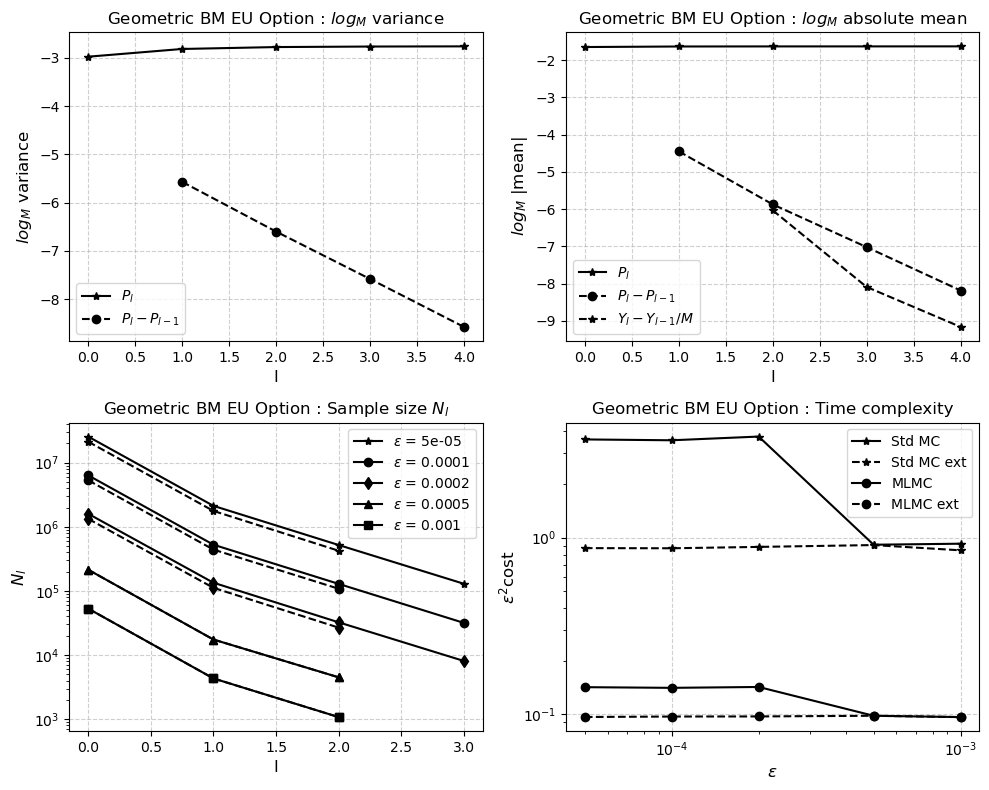

In [18]:
# Param plot
title = "Geometric BM EU Option"
refinement_index_max = 4 # range of level to plot for both top plot
nb_samples = 4*10**6 # nb samples for both top plot
accuracy_array = [5*10**(-5), 10**(-4), 2*10**(-4), 5*10**(-4), 10**(-3)] # accuracy to use in multi level algo for both bottom plot

# Param option
T = 1 # maturity of option
K = 1 # strike of option
type_option = "CALL" # type of option
option_payoff = EuropeanVanillaOption(maturity=T, 
                                      strike=K, 
                                      type_option=type_option)

# Evaluation with Multi Level algorithm
multi_level_algorithm = MultiLevelMonteCarlo(price_model=price_model, 
                                             option_payoff=option_payoff, 
                                             param_multi_level=param_multi_level)

price_estimator_ml_mc = multi_level_algorithm.get_price()
conf_inter_multi_mc = multi_level_algorithm.get_confidence_interval(price=price_estimator_ml_mc, confidence=confidence)

# Plot creation
price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
param_plot_factory = ParamPlotFactory(title=title,
                                      refinement_index_max=refinement_index_max,
                                      nb_samples=nb_samples,
                                      accuracy_array=accuracy_array)

plot_factory = PlotFactory(price_model=price_model,
                           option_payoff=option_payoff,
                           param_multi_level=param_multi_level,
                           param_plot_factory=param_plot_factory)


print("Multi Level MC value:", price_estimator_ml_mc)
print(f"Multi Level {100*confidence}% confidence interval:", "[", conf_inter_multi_mc[0],";", conf_inter_multi_mc[1], "]")

plot_factory.display_plot()

# Asian option

For the Asian call option (resp. put), the payoff depends on the average of the underlying price over $[0, T]$. 

$$
\frac{1}{T} \int_0^T S_t \, dt
$$

We approximate the time integral by a trapezoidal rule:
$$
\bar{S}_m 
= \sum_{n=1}^{m} \tfrac{1}{2}\,\bigl(\hat{S}_n + \hat{S}_{n-1}\bigr)\,h_m,
$$
where $h_m = \tfrac{T}{m}$ and $\hat{S}_n$ denotes the approximation of Euler scheme of the price at time step $n$. The Asian payoff then reads
$$
P_{\text{asian}} 
= e^{-rT}\,\bigl(\bar{S}_m - K\bigr)_+, \quad\text{(resp, }e^{-rT}\,\bigl(K - \bar{S}_m\bigr)_+\text{)}
$$

Multi Level MC value: 0.05760861971270914
Multi Level 95.0% confidence interval: [ 0.05753282687791715 ; 0.05768441254750113 ]


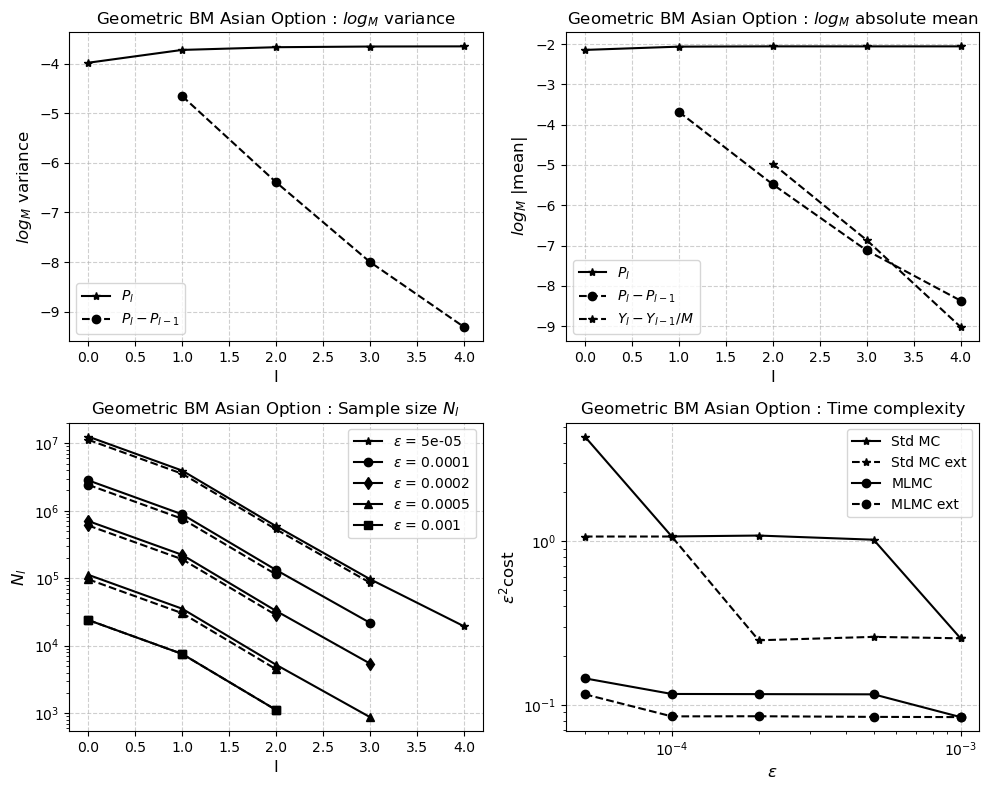

In [21]:
# Param plot
title = "Geometric BM Asian Option"
refinement_index_max = 4 # range of level to plot for both top plot
nb_samples = 4*10**6 # nb samples for both top plot (4*10**6 in the paper)
accuracy_array = [5*10**(-5), 10**(-4), 2*10**(-4), 5*10**(-4), 10**(-3)] # accuracy to use in multi level algo for both bottom plot

# Param option
T = 1 # maturity of option
K = 1 # strike of option
type_option = "CALL" # type of option
option_payoff = AsianOption(maturity=T, 
                            strike=K,
                            type_option=type_option)

# Evaluation with Multi Level algorithm
multi_level_algorithm = MultiLevelMonteCarlo(price_model=price_model, 
                                             option_payoff=option_payoff, 
                                             param_multi_level=param_multi_level)

price_estimator_ml_mc = multi_level_algorithm.get_price()
conf_inter_multi_mc = multi_level_algorithm.get_confidence_interval(price=price_estimator_ml_mc, confidence=confidence)

# Plot creation
price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
param_plot_factory = ParamPlotFactory(title=title, 
                                      refinement_index_max=refinement_index_max, 
                                      nb_samples=nb_samples,
                                      accuracy_array=accuracy_array)

plot_factory = PlotFactory(price_model=price_model,
                           option_payoff=option_payoff, 
                           param_multi_level=param_multi_level,
                           param_plot_factory=param_plot_factory)

print("Multi Level MC value:", price_estimator_ml_mc)
print(f"Multi Level {100*confidence}% confidence interval:", "[", conf_inter_multi_mc[0],";", conf_inter_multi_mc[1], "]")

plot_factory.display_plot()

# Lookback option

A lookback call payoff at maturity $T$ is of the form
$$
P_{\text{lookback}}
= e^{-rT}\,\Bigl(\hat{S}_T - \min_{0 \le t \le T}\hat{S}_t\Bigr).
$$
In practice, with a geometric Brownian dynamic for the price, we approximate the minimum by
$$
\hat{S}_{\min,m}
= \Bigl(\min_{m} \hat{S}_m\Bigr)\Bigl(1 - \beta^*\,\sigma\,\sqrt{h_m}\Bigr),
$$
where $\beta^* \approx 0.5826$ is a correction factor, $\sigma$ is the volatility parameter in the price dynamics, and $h_m = \tfrac{T}{m}$. The payoff then becomes
$$
P_{\text{lookback}}
= e^{-rT}\,\bigl(\hat{S}_T - \hat{S}_{\min,\ell}\bigr).
$$


Multi Level MC value: 0.1722059983947362
Multi Level 95.0% confidence interval: [ 0.17214269938741533 ; 0.17226929740205704 ]


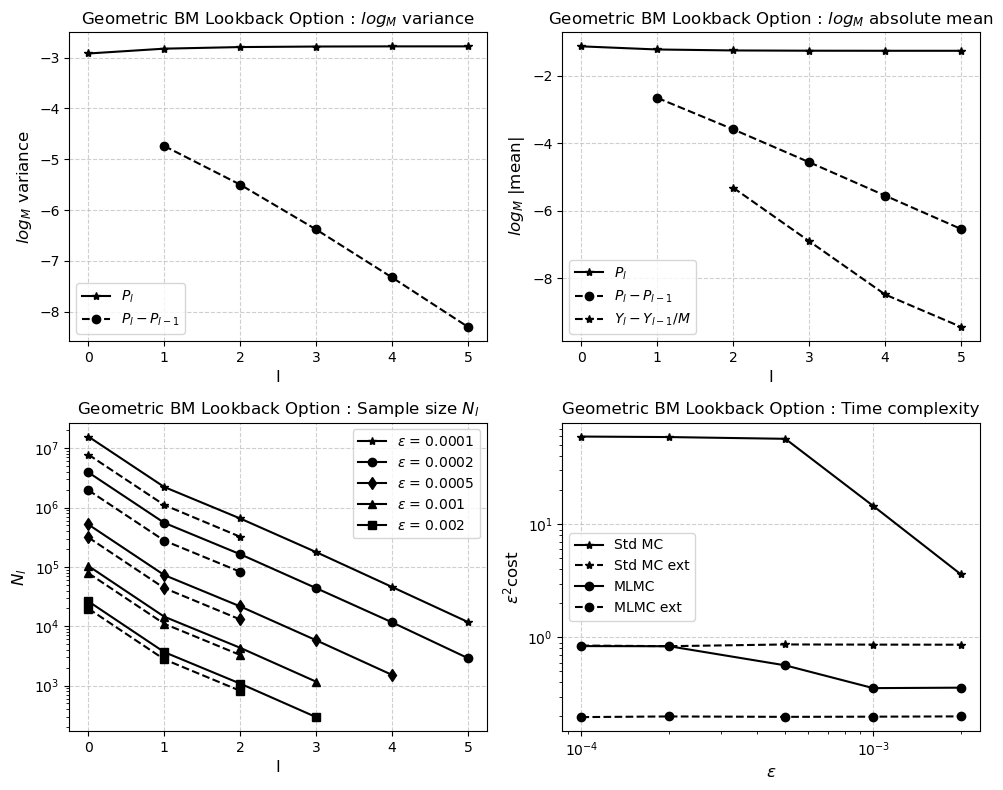

In [13]:
# Param plot
title = "Geometric BM Lookback Option"
refinement_index_max = 5 # range of level to plot for both top plot
nb_samples = 4*10**6 # nb samples for both top plot (4*10**6 in the paper)
accuracy_array = [10**(-4), 2*10**(-4), 5*10**(-4), 10**(-3), 2*10**(-3)] # accuracy to use in multi level algo for both bottom plot


# Param option
T = 1 # maturity of option
option_payoff = LookbackOption(maturity=T)

# Evaluation with Multi Level algorithm
multi_level_algorithm = MultiLevelMonteCarlo(price_model=price_model, 
                                             option_payoff=option_payoff, 
                                             param_multi_level=param_multi_level)

price_estimator_ml_mc = multi_level_algorithm.get_price()
conf_inter_multi_mc = multi_level_algorithm.get_confidence_interval(price=price_estimator_ml_mc, confidence=confidence)

# Plot creation
price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
param_plot_factory = ParamPlotFactory(title=title, 
                                      refinement_index_max=refinement_index_max, 
                                      nb_samples=nb_samples,
                                      accuracy_array=accuracy_array)

plot_factory = PlotFactory(price_model=price_model, 
                           option_payoff=option_payoff, 
                           param_multi_level=param_multi_level,
                           param_plot_factory=param_plot_factory)

print("Multi Level MC value:", price_estimator_ml_mc)
print(f"Multi Level {100*confidence}% confidence interval:", "[", conf_inter_multi_mc[0],";", conf_inter_multi_mc[1], "]")

plot_factory.display_plot()

# Digital option

A digital call option (resp. put) pays $1$ unit of cash if $\hat{S}_T$ exceeds the strike $K$ at maturity, and $0$ otherwise. Its payoff is
$$
P_{\text{digital}}
= e^{-rT}\,\mathbf{1}_{\{\hat{S}_T > K\}}, \quad\text{(resp, }e^{-rT}\,\mathbf{1}_{\{\hat{S}_T < K\}}\text{)}
$$


Multi Level MC value: 0.531097763746611
Multi Level 95.0% confidence interval: [ 0.5305752717344511 ; 0.5316202557587709 ]


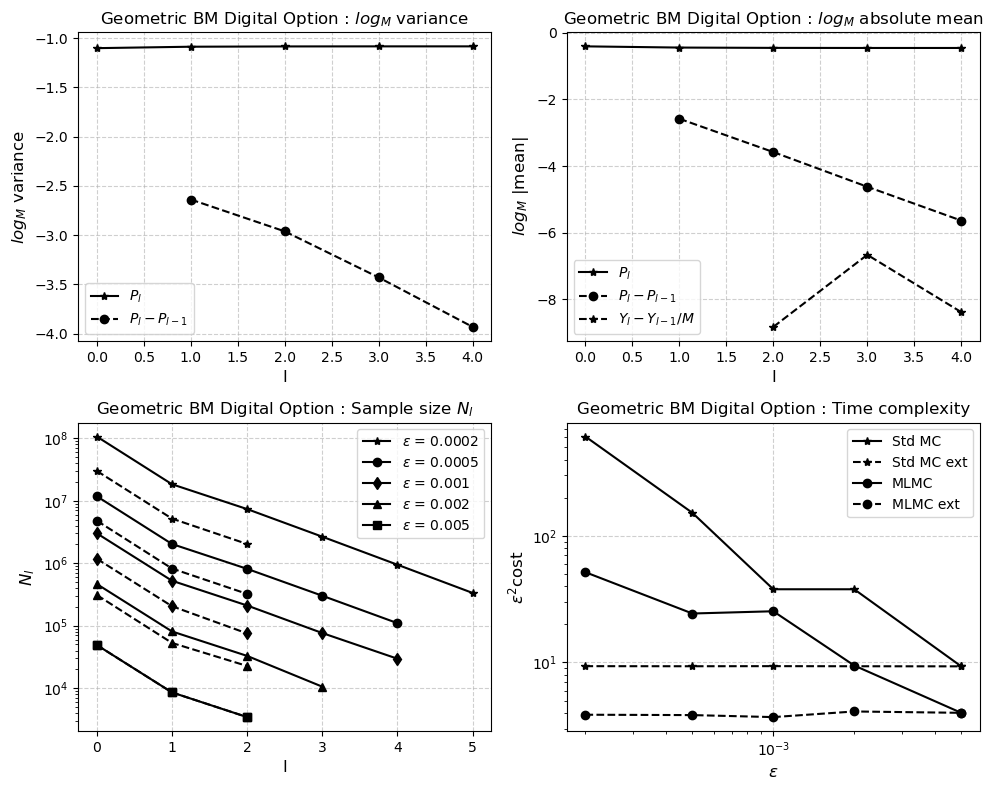

In [13]:
# Param plot
title = "Geometric BM Digital Option"
refinement_index_max = 4 # range of level to plot for both top plot
nb_samples = 4*10**6 # nb samples for both top plot (4*10**6 in the paper)
accuracy_array = [2*10**(-4), 5*10**(-4), 10**(-3), 2*10**(-3), 5*10**(-3)] # accuracy to use in multi level algo for both bottom plot

# Param option
T = 1 # maturity of option
K = 1 # strike of option
type_option = "CALL" # type of option
option_payoff = DigitalOption(maturity=T, 
                              strike=K,
                              type_option=type_option)

# Evaluation with Multi Level algorithm
param_multi_level.accuracy = 10**(-3) # For digital option we lower a bit epsilon as highly time consuming
multi_level_algorithm = MultiLevelMonteCarlo(price_model=price_model, 
                                             option_payoff=option_payoff, 
                                             param_multi_level=param_multi_level)

price_estimator_ml_mc = multi_level_algorithm.get_price()
conf_inter_multi_mc = multi_level_algorithm.get_confidence_interval(price=price_estimator_ml_mc, confidence=confidence)

# Plot creation
price_model.generate_gaussian.counter = 0 # reinitialize counter of gaussian generation
param_plot_factory = ParamPlotFactory(title=title, 
                                      refinement_index_max=refinement_index_max, 
                                      nb_samples=nb_samples,
                                      accuracy_array=accuracy_array)

plot_factory = PlotFactory(price_model=price_model, 
                           option_payoff=option_payoff, 
                           param_multi_level=param_multi_level,
                           param_plot_factory=param_plot_factory)

print("Multi Level MC value:", price_estimator_ml_mc)
print(f"Multi Level {100*confidence}% confidence interval:", "[", conf_inter_multi_mc[0],";", conf_inter_multi_mc[1], "]")

plot_factory.display_plot()

# EU option pricing with Heston stochastic volatility

In [61]:
# Price dynamics
S_0 = 1 # init value of price
V_0 = 0.04 # init value of stochastic vol
r = 0.05 # drift (interest rate on risk neutral)
sigma = 0.2 # mean of stochastic vol
lambda_ = 5 # mean reversion parameter
ksi = 0.25 # volatility of stochastic volatility parameter
rho = -0.5 # correlation between diffusion
generate_gaussian.counter = 0 # reinitialize counter of gaussian generation

price_model = HestonStochasticVolatility(init_value_price=S_0, 
                                         init_value_vol=V_0, 
                                         drift=r, 
                                         sigma=sigma, 
                                         lambda_=lambda_, 
                                         ksi=ksi, 
                                         rho=rho,
                                         generate_gaussian=generate_gaussian)

# Parametrization of Multi Level algorithm
epsilon = 10**(-4) # accuracy (RMSE) to choose
M = 4 # refinement factor in the paper
N_L = 10**4 # in the paper (in step 2 of numerical algorithm)
richardson_ext = False # use or not Richardson extrapolation

param_multi_level= ParamMultiLevel(accuracy=epsilon, 
                                   refinement_factor=M, 
                                   init_nb_samples=N_L,
                                   richardson_ext=richardson_ext,
                                   batch_size=batch_size)

Multi Level MC value: 0.10461258892054208
Multi Level 95.0% confidence interval: [ 0.10454539082621399 ; 0.10467978701487017 ]


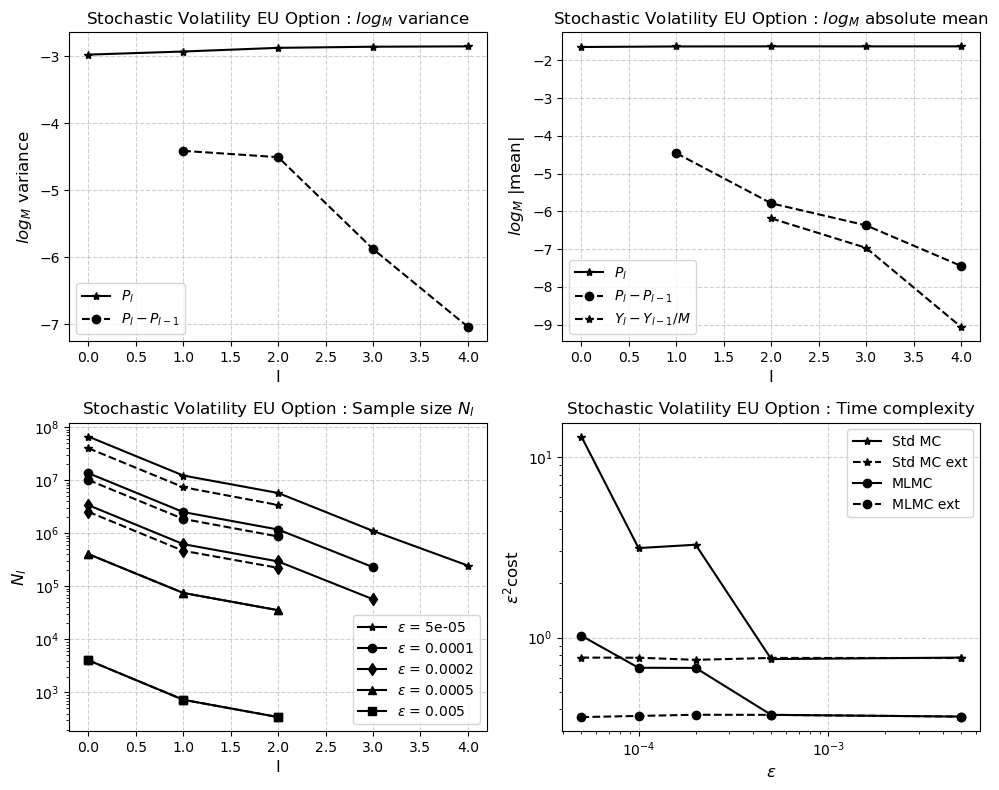

In [62]:
# Param plot
title = "Stochastic Volatility EU Option"
refinement_index_max = 4 # range of level to plot for both top plot
nb_samples = 4*10**6 # nb samples for both top plot (4*10**6 in the paper)
accuracy_array = [5*10**(-5), 10**(-4), 2*10**(-4), 5*10**(-4), 5*10**(-3)] # accuracy to use in multi level algo for both bottom plot

# Param option
T = 1 # maturity of option
K = 1 # strike of option
type_option = "CALL" # type of option
option_payoff = EuropeanVanillaOption(maturity=T, 
                                      strike=K, 
                                      type_option=type_option)

# Evaluation with Multi Level algorithm
multi_level_algorithm = MultiLevelMonteCarlo(price_model=price_model, 
                                             option_payoff=option_payoff, 
                                             param_multi_level=param_multi_level)

price_estimator_ml_mc = multi_level_algorithm.get_price()
conf_inter_multi_mc = multi_level_algorithm.get_confidence_interval(price=price_estimator_ml_mc, confidence=confidence)

# Plot creation
param_plot_factory = ParamPlotFactory(title=title, 
                                      refinement_index_max=refinement_index_max, 
                                      nb_samples=nb_samples,
                                      accuracy_array=accuracy_array)

plot_factory = PlotFactory(price_model=price_model,
                           option_payoff=option_payoff, 
                           param_multi_level=param_multi_level,
                           param_plot_factory=param_plot_factory)

print("Multi Level MC value:", price_estimator_ml_mc)
print(f"Multi Level {100*confidence}% confidence interval:", "[", conf_inter_multi_mc[0],";", conf_inter_multi_mc[1], "]")

plot_factory.display_plot()